In [29]:
import math
import copy
import numpy as np
import scipy.sparse as ssp
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt
import cvxpy as cp  
import time
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [30]:
# initial value

nRotors = 8
Deg2Rad = np.pi /180
Rad2Deg = 1/Deg2Rad

dt = 0.01            # control frequency
tf = 4.5             # final time
g = 9.81              # m/s^2

l = 1.0              # m
m = 23.56            # kg
Ix = 1.676           # kg m^2
Iy = 1.676           # kg m^2
Iz = 2.9743          # kg m^2

# rotor characteristics
kf = 1.1             # N / V^2
kt = 0.52            # N m / V^2 
rotor_limit = 10                  # rotor limit
rotor_sr_limit = rotor_limit/0.1  # rotor slew rate limit
omega_rotor, zeta_rotor = 40, 0.8

t_fail = 3         # 고장 시간
t_detect = 0.2     # 고장 검출에 걸리는 시간  
r_fail = 5         # 고장 로터 번호
c = l  
loc = np.zeros((nRotors,3))
loc[0] = np.array([ 0.25*c,  2.5*c, 0]) 
loc[1] = np.array([ 0.25*c,  1.5*c, 0])
loc[2] = np.array([ 0.25*c, -1.5*c, 0])
loc[3] = np.array([ 0.25*c, -2.5*c, 0])
loc[4] = np.array([-0.75*c, -2.5*c, 0])
loc[5] = np.array([-0.75*c, -1.5*c, 0])
loc[6] = np.array([-0.75*c,  1.5*c, 0])
loc[7] = np.array([-0.75*c,  2.5*c, 0])
thrust = np.array([0, 0, -kf])
moments = np.cross(loc, thrust)
A = np.zeros((4,nRotors))        # rotor speed (sq) to control (thr/torque)
A[0,:] = np.ones(nRotors)*kf     # thrust
A[[1,2],:] = moments[:,[0,1]].T  # roll moment , pitch moment
A[3,0::2] = -kt                  # yaw moment (CW rotors) 
A[3,1::2] =  kt                  # yaw moment (CCW rotors)
pinvA = np.linalg.pinv(A)

In [211]:
def  compute_guidance_cvx(position, velocity, psi, tgo,ub,lb):

    delt = 0.05
    T = tgo
    N = int(T/delt)
    
    if N==0:
        thrust, phi_cmd, the_cmd, psi_cmd = 0, 0, 0, 0 
        return np.array([thrust,phi_cmd,the_cmd,psi_cmd])

    r_des = np.zeros(3)
    r_des[0] = 1
    r_des[1] = 1
    r_des[2] = 0

    v_des = np.zeros(3)

    g_pin = np.zeros(3)
    g_pin[2] = 9.8
    T2 = ub
    T1 = lb

    T_c = cp.Variable((3*N))
    r_pin = cp.Variable((3,N+1))
    v_pin = cp.Variable((3,N+1))
    gamma = cp.Variable((N))

    mag = cp.norm(gamma,2)
    # mag = cp.norm(T_c,2)
    obj = cp.Minimize(mag)

    # sum of root
    # obj=0
    # for t in range(N+1):
    #     obj += cp.norm(T_c[:,t],2)   
    # obj = cp.Minimize(obj)
    
    constr = [ 
        v_pin[:,0] == velocity,
        r_pin[:,0] == position,
        v_pin[:,-1] == v_des,
        r_pin[:,-1] == r_des
        ]
    
    # 3축 최적 추력 명령 산출
    
    for t in range(N):
        constr += [        
            r_pin[:,t+1] == r_pin[:,t] + v_pin[:,t]*delt,
            v_pin[:,t+1] == v_pin[:,t] + ( T_c[3*t:3*(t+1)]/m + g_pin )*delt,
            cp.norm(T_c[3*t:3*(t+1)]) <= gamma[t], gamma[t] <= T2, gamma[t] >= T1,
            T_c[3*t+2]<=0,
        ]

    prob = cp.Problem(obj, constr)
    prob.solve(verbose=False,solver=cp.ECOS,reltol=1e-10)

    if prob.status=='optimal' or prob.status=='optimal_inaccurate':
        opt_T_c = np.reshape(T_c.value,(3,N),order='F')
        T_n, T_e, T_d = opt_T_c[0,:],opt_T_c[1,:],opt_T_c[2,:]
    
    # 추력 명령 -> 자세각 명령 변환 loop
    
        T_a =  T_n*np.cos(psi) + T_e*np.sin(psi)
        T_b = -T_n*np.sin(psi) + T_e*np.cos(psi)
    
        thrust = np.linalg.norm(opt_T_c,axis=0)
        the_cmd = -np.arctan2(T_a,-T_d)
        phi_cmd = np.arcsin(T_b/thrust)
        psi_cmd = psi
        print(tgo, prob.status)
    
    else:
        thrust, phi_cmd, the_cmd, psi_cmd = 0, 0, 0, 0
        print(tgo, prob.status)
    
    if position[2]>=0:
        thrust, phi_cmd, the_cmd, psi_cmd = 0, 0, 0, 0 
    
    return np.array([thrust,phi_cmd,the_cmd,psi_cmd])

In [213]:
def ADMM_compute_guidance(position, velocity, psi, tgo,ub,lb):
    delt = 0.05
    T = tgo
    N = int(T/delt)

    if N == 0 or N == 1:
        thrust, phi_cmd, the_cmd, psi_cmd = 0, 0, 0, 0 
        return np.array([thrust,phi_cmd,the_cmd,psi_cmd])
    
    Tc = ub
    Tc_lower = lb
    rho = 1e10

    G = np.zeros((3,3*N))
    H = np.zeros((3,3*N))
    I = np.eye(3*N)
    
    for i in range(N):
        G[:, 3*i:3*(i+1)] = (N-1-i)*delt**2/m*np.eye(3)
        H[:, 3*i:3*(i+1)] =  delt/m*np.eye(3)

    A = ssp.vstack((ssp.csr_matrix(G),ssp.csr_matrix(H),ssp.csr_matrix(I) ))
    B = ssp.vstack((ssp.csr_matrix(np.zeros((6,3*N))),ssp.csr_matrix(I) ))
    
    r_0 = position
    v_0 = velocity

    r_des = np.zeros(3)
    r_des[0] = 1
    r_des[1] = 1
    r_des[2] = 0

    v_des = np.zeros(3)

    g_pin = np.zeros(3)
    g_pin[2] = 9.8

    r = r_des - (r_0 + N*delt*v_0 + delt**2*(N-1)*N/2*g_pin)
    v = v_des - (v_0 + N*delt*g_pin)

    y = np.hstack((r,v,np.zeros(3*N)))
    y_l2 = np.linalg.norm(y)
    A_init = ssp.vstack((ssp.csr_matrix(G),ssp.csr_matrix(H),ssp.csr_matrix(I*np.sqrt(2/rho))))

    z = sla.lsqr(A_init,y)[0]
    z_last = z
    u = np.zeros(3*N+6)

    mu = 10
    tau_incr,tau_decr = 2,2
    status = "Infeasible"

    max_iter = 1000

    for i in range(max_iter):
        A_all = ssp.vstack((A,ssp.csr_matrix(2*I/np.sqrt(rho))))
        c = np.hstack((y + B*z - u,np.zeros(3*N)))
        x, istop = sla.lsqr(A_all,c)[:2]    # x update
        # x, istop = sla.lsqr(A,y + B*z - u)[:2]
        if istop == 0:
            break

        for j in range(N):
            v = x + u[6:]               # z update
            z[2+3*j] = min(0,v[2+3*j])
            Thr = np.sqrt(v[3*j]**2 + v[3*j+1]**2 + z[3*j+2]**2)
            
            if  Thr > Tc:
                z[3*j] = Tc*v[3*j]/Thr
                z[3*j+1] = Tc*v[3*j+1]/Thr
                z[3*j+2] = Tc*z[3*j+2]/Thr
            elif Thr < Tc_lower:
                z[3*j] = Tc_lower*v[3*j]/Thr
                z[3*j+1] = Tc_lower*v[3*j+1]/Thr
                z[3*j+2] = Tc_lower*z[3*j+2]/Thr
            else:
                z[3*j] = v[3*j]
                z[3*j+1] = v[3*j+1]
                z[3*j+2] = z[3*j+2]

        r = A*x - B*z -y            # Primal residual
        s = rho*A.T@B@(z - z_last)  # Dual residual
        u = u + r                   # u update, dual ascent

        primal_res_l2 = np.linalg.norm(r)
        dual_res_l2 = np.linalg.norm(s)


        alpha = 4/np.pi*np.arctan((np.linalg.norm(r_des-r_0)**2)-2) + 5
        abstol, reltol = 1/rho, 1e-4*2
        ptol = np.sqrt(3*N+6)*abstol + reltol*max( np.linalg.norm(A*x), np.linalg.norm(B*z), y_l2)
        dtol = np.sqrt(3*N)*abstol + reltol*np.linalg.norm(A.T@(u*rho))

        z_last = z
        
        if  primal_res_l2 <= ptol and dual_res_l2 <= dtol:    # Stopping Criteria
            status = "Solved"
            break
        # status = "Solved"
        if primal_res_l2 > mu*dual_res_l2:          # update rho
            rho = tau_incr*rho
        elif primal_res_l2 < mu*dual_res_l2:
            rho = rho/tau_decr
        else:
            rho = rho

    print("iter:",i,"status:",status,"pres_l2:",primal_res_l2, "dres_l2:",dual_res_l2,"ptol:", ptol,"dtol:",dtol,"alpha:",alpha)
    # print(np.linalg.norm(u*rho))

    if position[2]>=0 or istop == 0 or status == "Infeasible":
        zero = np.zeros(N)
        thrust, phi_cmd, the_cmd, psi_cmd = zero, zero, zero, zero 
    
    else:
        opt_T_c = np.reshape(z,(3,N),order='F')
        T_n, T_e, T_d = opt_T_c[0,:],opt_T_c[1,:],opt_T_c[2,:]
        T_a =  T_n*np.cos(psi) + T_e*np.sin(psi)
        T_b = -T_n*np.sin(psi) + T_e*np.cos(psi)

        thrust = np.linalg.norm(opt_T_c,axis=0)
        the_cmd = -np.arctan2(T_a,-T_d)
        phi_cmd = np.arcsin(T_b/thrust)
        psi_cmd = psi

    return np.array([thrust,phi_cmd,the_cmd,psi_cmd])    

In [220]:
position = np.array([1,2,-1])
velocity = np.array([0,0,0])
psi = 0
tgo = 1.4
dt = 0.05
ub = 720
lb = 210

t = np.arange(0., tgo, dt)

thrust, phi_cmd, the_cmd, psi_cmd = compute_guidance_cvx(position, velocity, psi, tgo,ub,lb)
thrust_admm, phi_cmd_admm, the_cmd_admm, psi_cmd_admm = ADMM_compute_guidance(position, velocity, psi, tgo,ub,lb)

1.4 optimal
iter: 538 status: Solved pres_l2: 0.2455821398448468 dres_l2: 0.0 ptol: 0.24590829651855797 dtol: inf alpha: 5.000000000000001


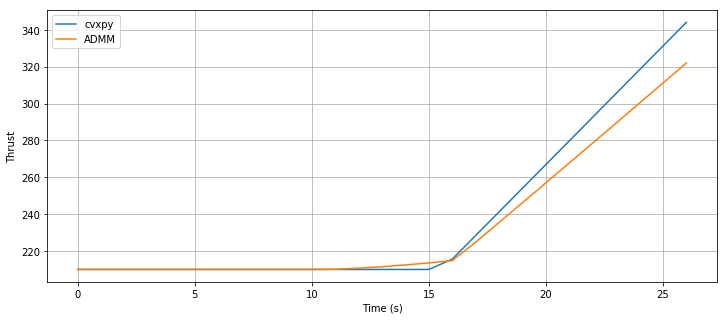

In [221]:
plt.figure(num=6, figsize=(12,5))
plt.plot(thrust,label='cvxpy')
plt.plot(thrust_admm,label='ADMM')
plt.ylabel("Thrust")
plt.xlabel("Time (s)")
plt.grid()
plt.legend()